# W/δ Analysis
The following is taken from U.S. Naval Test Pilot School. ‘USNTPS Fixed Wing Performance (USNTPS-FTM-NO. 108)’. In U.S. Naval Test Pilot School Flight Test Manual, 1992.

## Required Equations

1. Calibrated Pressure Altitude
$$ H_c = H_o + \Delta H_{P_{ic}} + \Delta H_{pos} $$

2. Ambient Temperature
$$ T_a = T_o + \Delta T_{ic} $$

3. Calibrated airspeed
$$ V_c = V_o + \Delta V_{ic} + \Delta V_{pos} $$

4. Density ratio
$$ \sigma = \frac{\rho_a}{\rho_{ssl}} $$

5. Pressure ratio
$$ \delta = \frac{P_a}{P_{ssl}} $$

6. Temperature ratio
$$ \theta = \frac{T_a}{T_{ssl}} $$

7. True airspeed
$$ V_T = \frac{V_c}{\sqrt{\sigma}} $$

8. Mach number
$$ M = \frac{V_T}{a_{ssl} \sqrt{\theta}} $$

9. Referred fuel flow
$$ \dot{W}_{f_{ref}} = \frac{\dot{W}_f}{\delta \sqrt{\theta}} $$

10. Referred aircraft weight
$$ W_{ref} = \frac{W}{\delta} $$

### Variables
- $a_{ssl}$: Standard sea level speed of sound, 661.483 kn
- $\delta$: Pressure ratio
- $\Delta H_{P_{ic}}$: Altimeter instrument correction, ft
- $\Delta H_{pos}$: Altimeter position error, ft
- $\Delta T_{ic}$: Temperature instrument correction, °C
- $\Delta V_{ic}$: Airspeed instrument correction, kn
- $\Delta V_{pos}$: Airspeed position error, kn
- $H_c$: Calibrated pressure altitude, ft
- $H_o$: Observed pressure altitude, ft
- $M$: Mach number
- $P_a$: Ambient pressure, psf
- $P_{ssl}$: Standard sea level pressure, 2116.217 psf
- $\theta$: Temperature ratio
- $\rho_a$: Ambient air density, slugs/ft³
- $\rho_{ssl}$: Standard sea level air density, 0.0023769 slugs/ft³
- $\sigma$: Density ratio
- $T_a$: Ambient temperature, °C
- $T_o$: Observed temperature, °C
- $T_{ssl}$: Standard sea level temperature, °C
- $V_c$: Calibrated airspeed, kn
- $V_o$: Observed airspeed, kn
- $V_T$: True airspeed, kn
- $W$: Weight, lb
- $\dot{W}_f$: Fuel flow, lb/h
- $\dot{W}_{f_{ref}}$: Referred fuel flow, lb/h
- $W_{ref}$: Referred aircraft weight, lb

## Pilot's Data
The following are  necessary to complete the test results:
- $W_f,$ or fuel remaining and time of flight
- torque
- engine speed
- $T_a$
- $V_o$
- $H_{P_o}$

The following can provide correlating information:
- Angle of attack
- N1
- EGT
- etc.

## Order of Analysis
Here's the information in a markdown table:

| Step | Parameter                | Notation     | Formula   | Units     | Remarks                              |
|------|---------------------------|--------------|-----------|-----------|--------------------------------------|
| 1    | Observed altitude         | $H_o$       |           | ft        |                                      |
| 2    | Altitude instrument correction | $\Delta H_{P_{ic}}$ |           | ft        | Lab calibration                     |
| 3    | Altitude position error   | $\Delta H_{pos}$ |       | ft        | Airspeed calibration                |
| 4    | Calibrated altitude       | $H_c$       | Eq 4.88   | ft        |                                      |
| 5    | Observed temperature      | $T_o$       |           | °C        |                                      |
| 6    | Temp instrument correction | $\Delta T_{ic}$ |     | °C        | Lab calibration                     |
| 7    | Ambient temperature       | $T_a$       | Eq 4.89   | °C        |                                      |
| 8    | Observed airspeed         | $V_o$       |           | kn        |                                      |
| 9    | Airspeed instrument correction | $\Delta V_{ic}$ | | kn        | Lab calibration                     |
| 10   | Airspeed position error   | $\Delta V_{pos}$ |      | kn        | Airspeed calibration                |
| 11   | Calibrated airspeed       | $V_c$       | Eq 4.90   | kn        |                                      |
| 12   | Ambient pressure          | $P_a$       |           | psf       | From Appendix VI, or calculated from 4 |
| 13   | Ambient air density       | $\rho_a$    |           | slugs/ft³ | From Appendix VI or calculated (see Chapter 2) |
| 14   | Density ratio             | $\sigma$    | Eq 4.77   |           | Or from Appendix VI                 |
| 15   | Pressure ratio            | $\delta$    | Eq 4.43   |           |                                      |
| 16   | Temperature ratio         | $\theta$    | Eq 4.38   |           |                                      |
| 17   | True airspeed             | $V_T$       | Eq 4.91   | kn        |                                      |
| 18   | Mach number               | $M$         | Eq 4.92   |           | Or from Mach indicator with instrument correction |
| 19   | Referred fuel flow        | $\dot{W}_{f_{ref}}$ | Eq 4.93 | lb/h |                                      |
| 20   | Referred weight           | $W_{ref}$   | Eq 4.94   | lb        |                                      |

## Python Code

In [76]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from atmosphere import Atmosphere

atm = Atmosphere()

### Constants

In [77]:
a_ssl = 661.483  # knots
P_ssl = 2116.217  # lb/ft^2
rho_ssl = 0.0023769  # slug/ft^3

### Functions

#### Calibrated Pressure Altitude
$$ H_c = H_o + \Delta H_{P_{ic}} + \Delta H_{pos} $$

In [78]:
def h_c(h_o, dh_ic, dh_pc):
    return h_o + dh_ic + dh_pc

#### Ambient Temperature
$$ T_a = T_o + \Delta T_{ic} $$

In [79]:
def t_a(t_o, dt_ic):
    return t_o + dt_ic

#### Calibrated airspeed
$$ V_c = V_o + \Delta V_{ic} + \Delta V_{pos} $$

In [80]:
def v_c(v_o, dv_ic, dv_pc):
    return v_o + dv_ic + dv_pc

#### Density ratio
$$ \sigma = \frac{\rho_a}{\rho_{ssl}} $$

In [81]:
def sigma(rho_a, rho_ssl):
    return rho_a / rho_ssl

#### Pressure ratio
$$ \delta = \frac{P_a}{P_{ssl}} $$

In [82]:
def delta(P_a, P_ssl):
    return P_a / P_ssl

#### Temperature ratio
$$ \theta = \frac{T_a}{T_{ssl}} $$

In [83]:
def theta(t_a, t_ssl):
    return t_a / t_ssl

#### True airspeed
$$ V_T = \frac{V_c}{\sqrt{\sigma}} $$

In [84]:
def v_t(v_c, sigma):
    return v_c / np.sqrt(sigma)

#### Mach number
$$ M = \frac{V_T}{a_{ssl} \sqrt{\theta}} $$

In [85]:
def mach(v_t, a_ssl, theta):
    return v_t / (a_ssl * np.sqrt(theta))

#### Referred fuel flow
$$ \dot{W}_{f_{ref}} = \frac{\dot{W}_f}{\delta \sqrt{\theta}} $$

In [86]:
def wf_ref(w_f, delta, theta):
    return w_f / (delta * np.sqrt(theta))

#### Referred aircraft weight
$$ W_{ref} = \frac{W}{\delta} $$

In [87]:
def w_ref(w, delta):
    return w / delta

### Load Data

In [88]:
df_21k = pd.read_excel("./data/w_d_data.xlsx", sheet_name="w_d 21086")
# df_18k = pd.read_excel("./demo_data/w_d_data.xlsx", sheet_name="w_d 18000")
# df_36k = pd.read_excel("./demo_data/w_d_data.xlsx", sheet_name="w_d 36000")
# df_52k = pd.read_excel("./demo_data/w_d_data.xlsx", sheet_name="w_d 52000")

# dfs = [df_18k, df_36k, df_52k]
# w_delta_values = [18000, 36000, 52000]
dfs = [df_21k]
w_delta_values = [21086]

for df, w_delta in zip(dfs, w_delta_values):
    df["w_delta"] = w_delta

### Test Parameters

In [89]:
w_s = 11900  # lb

### Data Analysis

In [90]:
dfs[0].columns

Index(['M', 'Hp (ft)', 'OAT (°C)', 'FF (lbs/hr)', 'Wt (lbs)', 'w_delta'], dtype='object')

In [91]:
def v_t_from_mach(M, a_ssl, theta):
    return M * a_ssl * np.sqrt(theta)


for df in dfs:
    df["h_c"] = df.apply(lambda row: h_c(row["Hp (ft)"], 0, 0), axis=1)
    df["t_a"] = df.apply(lambda row: t_a(row["OAT (°C)"], 0), axis=1)
    df["t_a_K"] = df["t_a"].apply(atm.celsius_to_kelvin)
    df["sigma_test"] = df.apply(
        lambda row: atm.calc_sigma(row["h_c"], row["t_a_K"]), axis=1
    )
    df["delta_test"] = df.apply(lambda row: atm.get_std_delta(row["h_c"]), axis=1)
    df["theta_test"] = df.apply(lambda row: theta(row["t_a_K"], atm.T_0), axis=1)
    df["v_t"] = df.apply(
        lambda row: v_t_from_mach(row["M"], a_ssl, row["theta_test"]), axis=1
    )
    df["wf_ref_dot"] = df.apply(
        lambda row: wf_ref(row["FF (lbs/hr)"], row["delta_test"], row["theta_test"]),
        axis=1,
    )
    df["w_ref"] = df.apply(
        lambda row: w_ref(row["Wt (lbs)"], row["delta_test"]), axis=1
    )
    df["w_s"] = w_s
    df["delta_std"] = df["w_s"] / df["w_delta"]
    df["h_ref"] = df.apply(lambda row: atm.get_h_from_delta(row["delta_std"]), axis=1)
    df["theta_std"] = df.apply(lambda row: atm.get_std_theta(row["h_ref"]), axis=1)
    df["sqrt_theta_std"] = np.sqrt(df["theta_std"])
    df["ff_std"] = df["FF (lbs/hr)"] * np.sqrt(df["theta_std"] / df["theta_test"])
    df["SR_std"] = df.apply(
        lambda row: (a_ssl * row["sqrt_theta_std"] * row["M"])
        / (row["wf_ref_dot"] * row["delta_std"] * row["sqrt_theta_std"]),
        axis=1,
    )

In [92]:
dfs[0]

,M,Hp (ft),OAT (°C),FF (lbs/hr),Wt (lbs),w_delta,h_c,t_a,t_a_K,sigma_test,...,v_t,wf_ref_dot,w_ref,w_s,delta_std,h_ref,theta_std,sqrt_theta_std,ff_std,SR_std
0,0.584,14850,-15,2600,11800,21086,14850.0,-15.0,258.15,0.633740,...,365.643862,4838.180694,20783.443073,11900,0.564355,14999.337493,0.896871,0.947033,2601.426228,0.141481
1,0.555,14950,-14,2400,11700,21086,14950.0,-14.0,259.15,0.628758,...,348.159272,4475.370529,20690.448858,11900,0.564355,14999.337493,0.896871,0.947033,2396.678977,0.145355
2,0.493,15070,-12,2000,11500,21086,15070.0,-12.0,261.15,0.620933,...,310.456895,3733.175326,20435.343140,11900,0.564355,14999.337493,0.896871,0.947033,1989.569946,0.154787
3,0.445,15280,-13,1750,11300,21086,15280.0,-13.0,260.15,0.618060,...,279.692810,3300.648459,20250.803963,11900,0.564355,14999.337493,0.896871,0.947033,1744.216397,0.158025



#### Plot

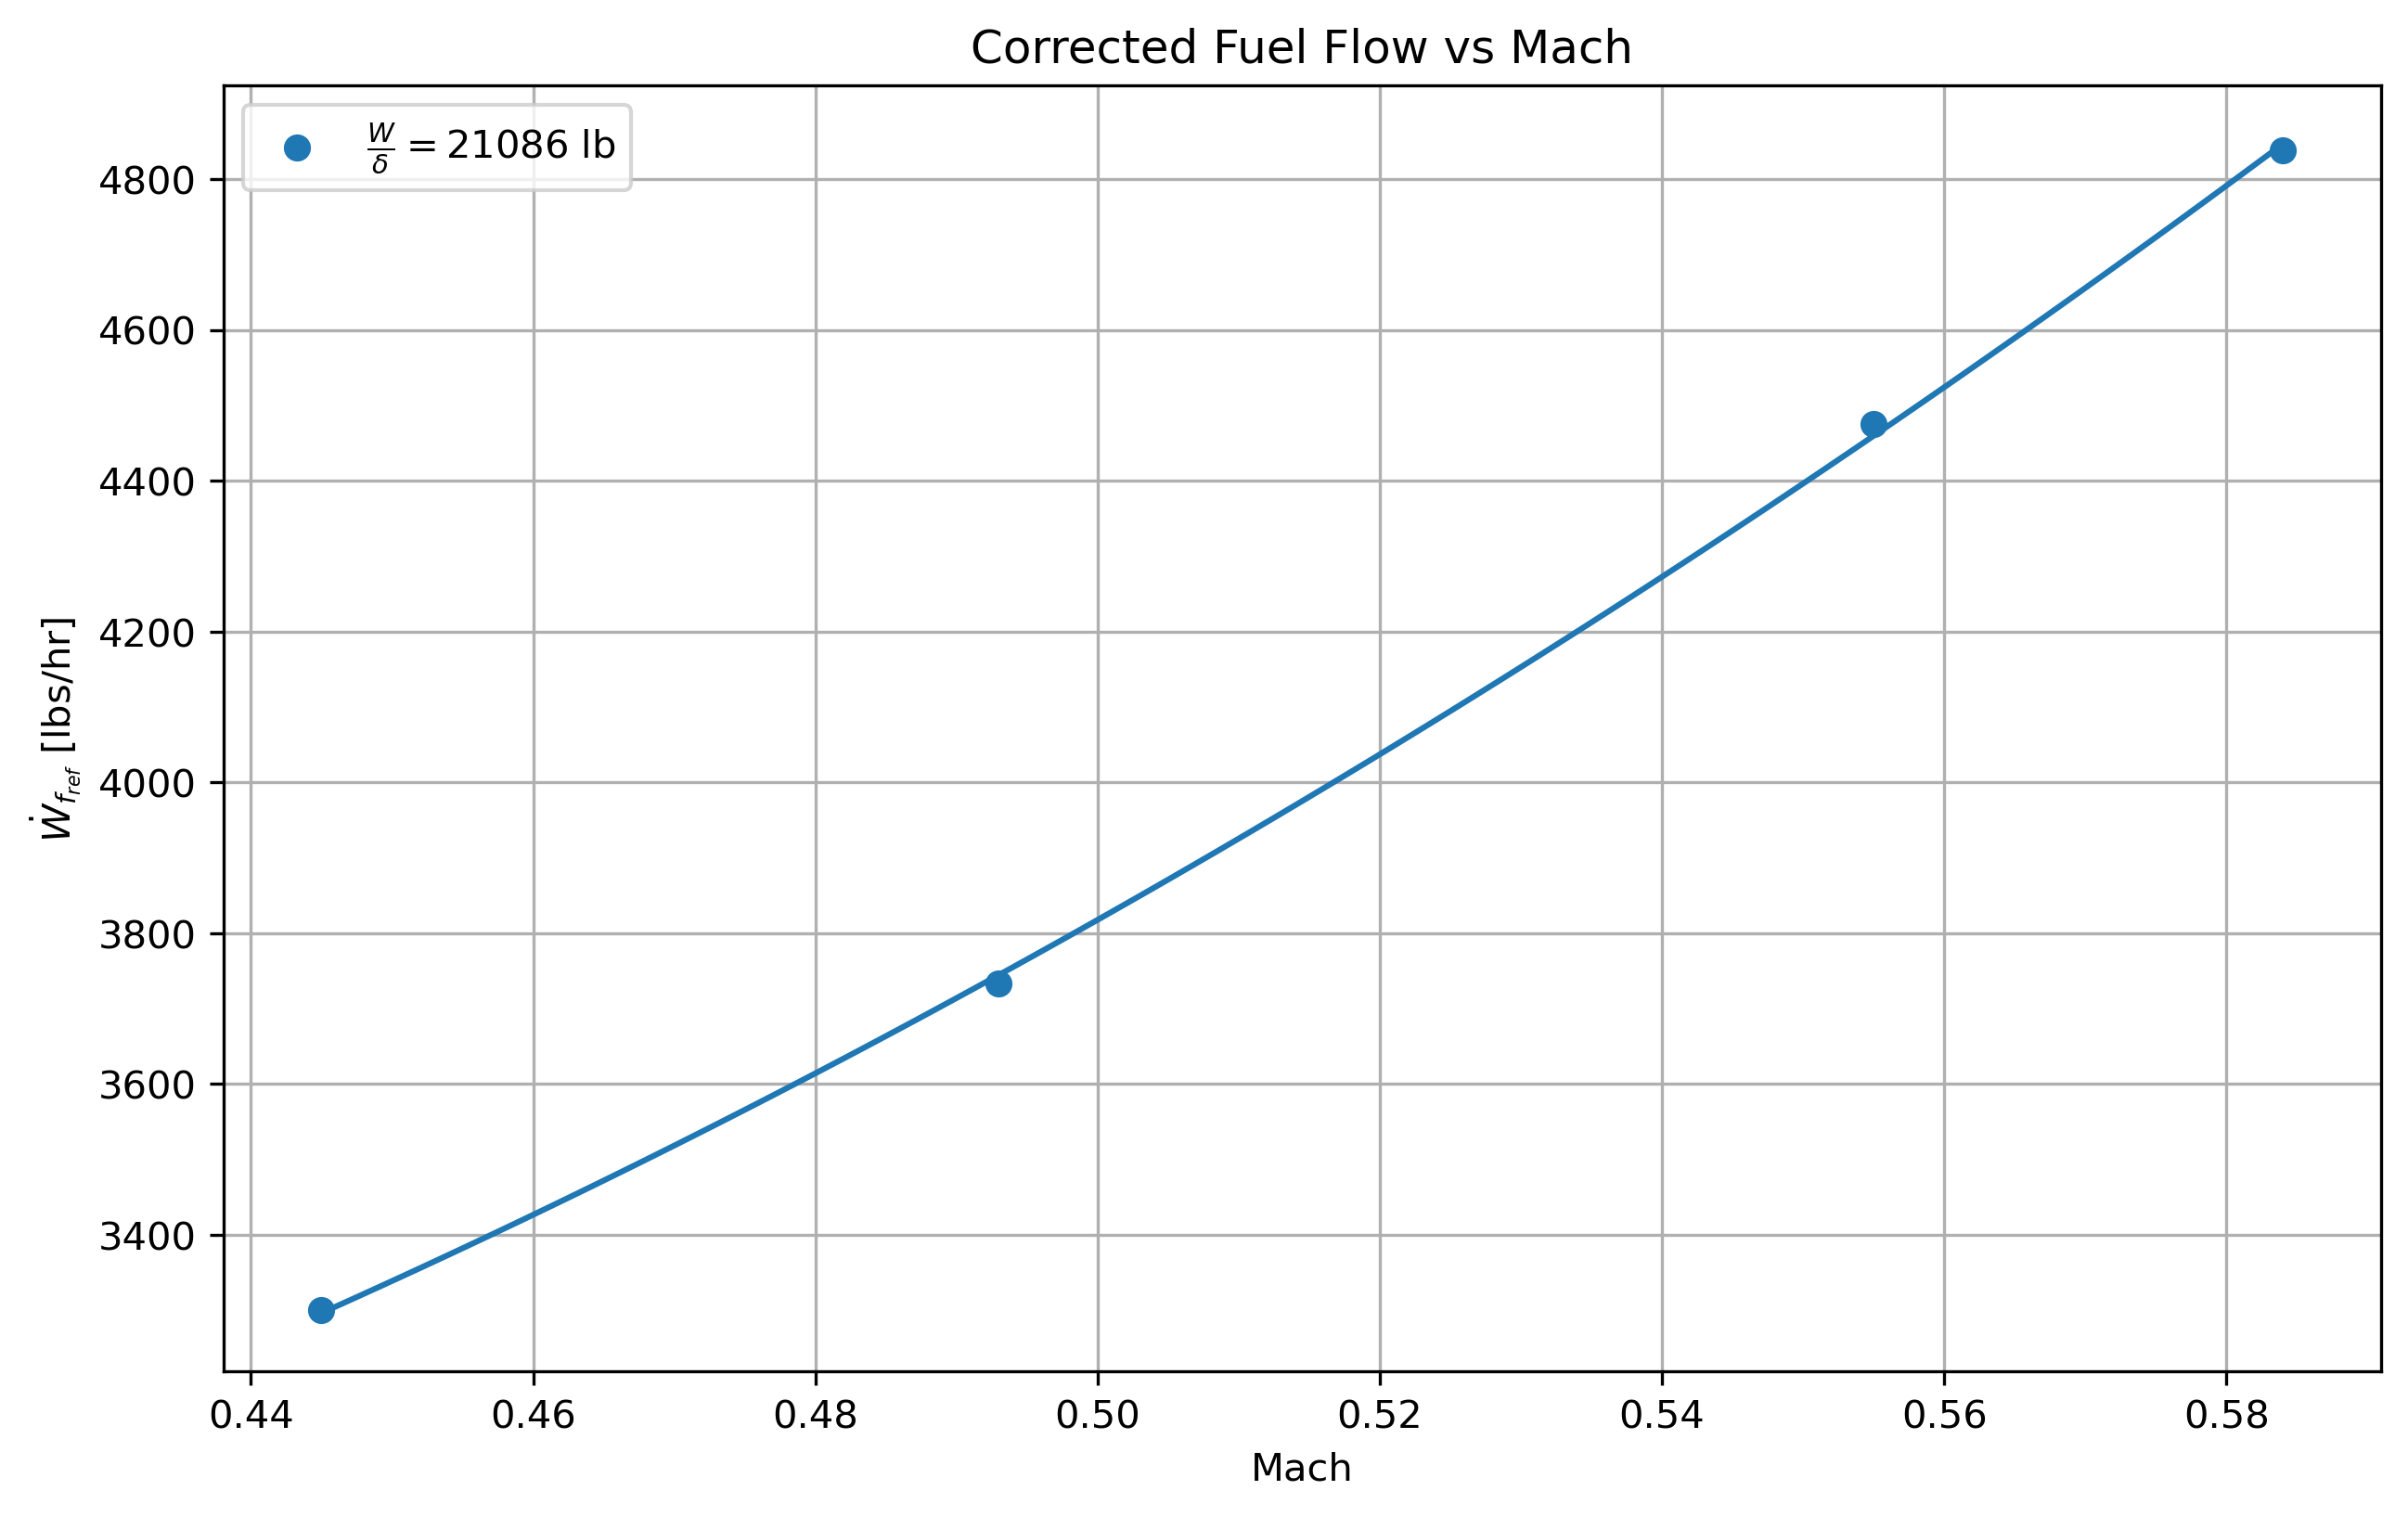

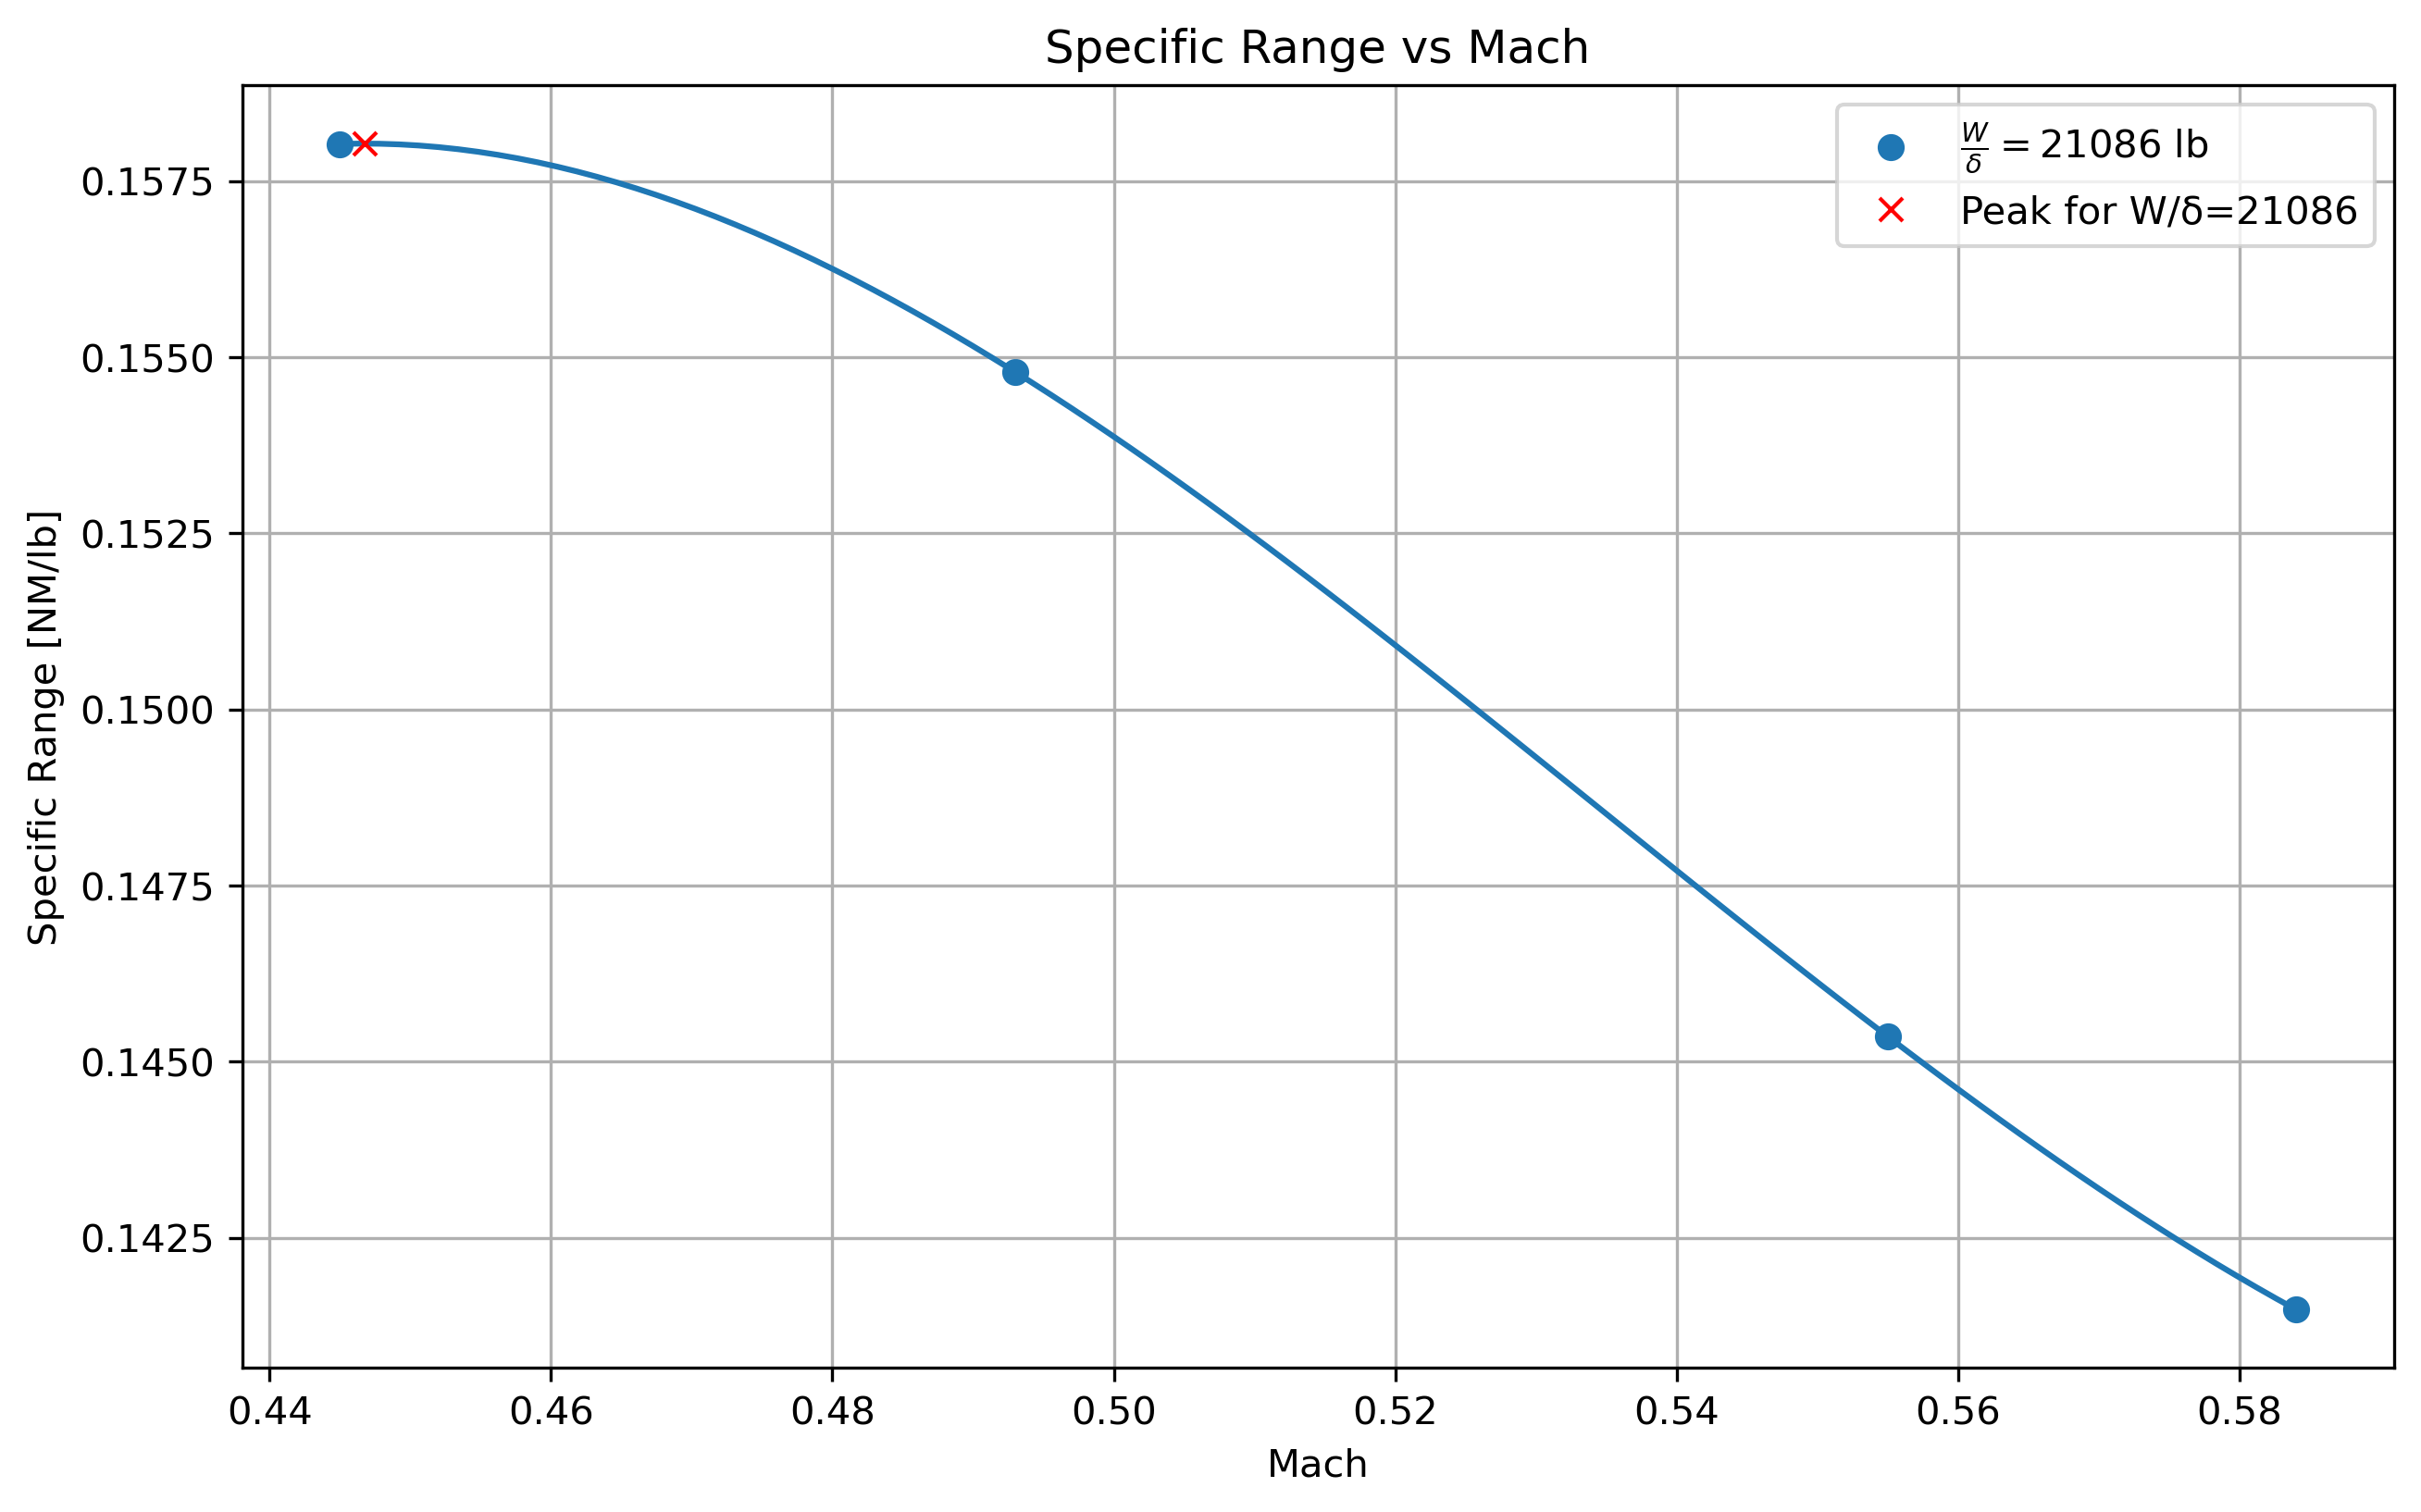

/var/folders/vd/qhfmft5n73n6bxz9rqb6m8h00000gn/T/ipykernel_28184/486960496.py:129: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(rf_df["w_delta"], rf_df["RF"], 2)
/var/folders/vd/qhfmft5n73n6bxz9rqb6m8h00000gn/T/ipykernel_28184/486960496.py:146: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


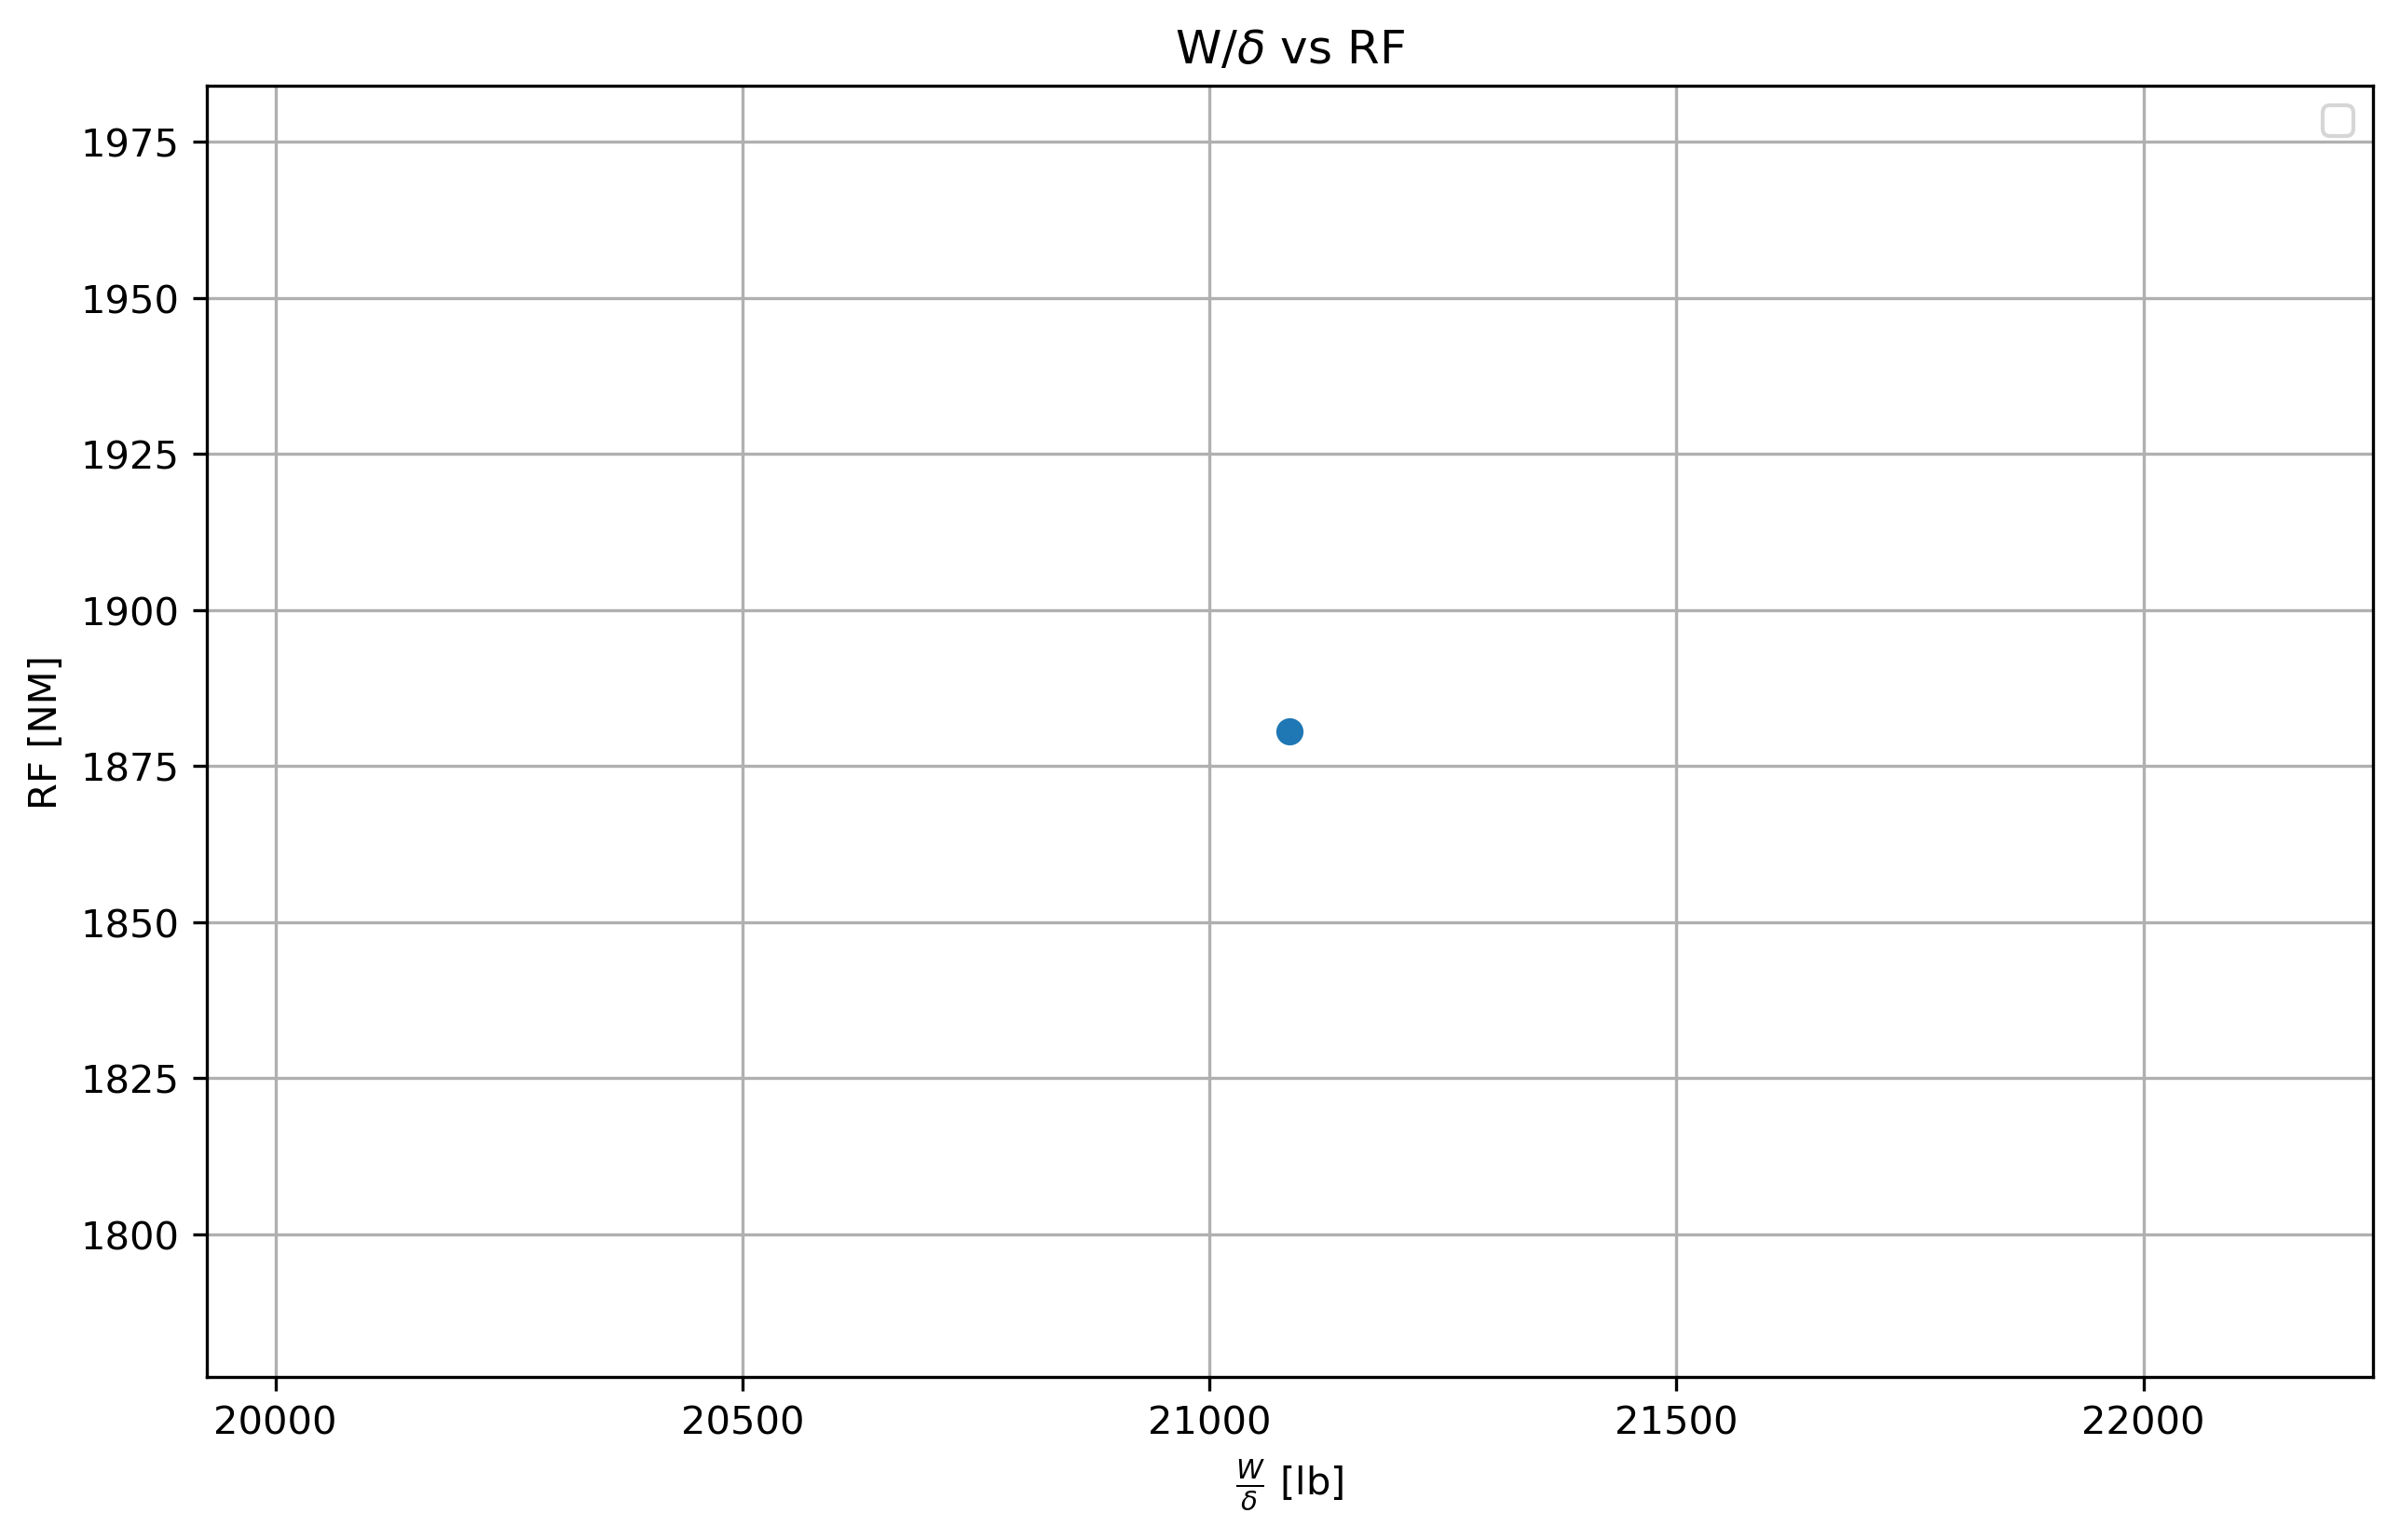

In [93]:
def find_critical_points_of_2nd_polynomial(coefficients, x_range):
    # Derivative of the 2nd-order polynomial: f'(x) = 2a * x + b
    a, b, _ = coefficients
    if a == 0:
        raise ValueError(
            "The leading coefficient cannot be zero for a quadratic polynomial."
        )

    # Calculate the critical point
    critical_point = -b / (2 * a)

    # Check if the critical point is within the x range
    if min(x_range) <= critical_point <= max(x_range):
        polynomial_fit = np.poly1d(coefficients)
        peak_y = polynomial_fit(critical_point)
        return critical_point, peak_y
    else:
        # Return None if there are no critical points within the range
        return None, None


def find_critical_points_of_3rd_polynomial(coefficients, x_range):
    # Derivative of the 3rd-order polynomial: f'(x) = 3a * x^2 + 2b * x + c
    derivative_coeffs = [3 * coefficients[0], 2 * coefficients[1], coefficients[2]]
    critical_points = np.roots(derivative_coeffs)

    # Filter real roots within the x range
    critical_points = [
        x
        for x in critical_points
        if x.imag == 0 and min(x_range) <= x.real <= max(x_range)
    ]
    real_critical_points = np.array([x.real for x in critical_points])

    # Evaluate polynomial at critical points to find peak
    peak_x = None
    peak_y = None
    if real_critical_points.size > 0:
        polynomial_fit = np.poly1d(coefficients)
        y_values = polynomial_fit(real_critical_points)
        max_index = np.argmax(y_values)  # Find index of maximum value
        peak_x = real_critical_points[max_index]
        peak_y = y_values[max_index]

    return peak_x, peak_y


# Corrected Fuel Flow vs Mach
plt.figure(figsize=(10, 6), dpi=300)
markers = ["o", "s", "^"]  # Different markers for each w/delta

for df, marker in zip(dfs, markers):
    plt.scatter(
        df["M"],
        df["wf_ref_dot"],
        marker=marker,
        label=r"$\frac{W}{\delta}=$" + str(df["w_delta"].iloc[0]) + " lb",
    )

    coefficients = np.polyfit(df["M"], df["wf_ref_dot"], 2)
    polynomial_fit = np.poly1d(coefficients)

    m_fit = np.linspace(min(df["M"]), max(df["M"]), 100)
    ff_fit = polynomial_fit(m_fit)
    plt.plot(m_fit, ff_fit)

    # Find the peak of the 3rd-order polynomial
    # peak_mach, peak_ff = find_critical_points_of_3rd_polynomial(coefficients, df["M"])
    # # Plot the peak point if it exists
    # if peak_mach is not None:
    #     df["min_ff"] = peak_ff
    #     df["min_ff_mach"] = peak_mach
    #     plt.plot(
    #         peak_mach, peak_ff, "rx", label=f"Peak for W/δ={df['w_delta'].iloc[0]}"
    #     )


plt.xlabel("Mach")
plt.ylabel(r"$\dot{W}_{f_{ref}}$ [lbs/hr]")
plt.title(r"Corrected Fuel Flow vs Mach")
plt.legend()
plt.grid()
plt.show()

# Specific Range vs Mach
rf_data = []
plt.figure(figsize=(10, 6), dpi=300)
for df, marker in zip(dfs, markers):
    plt.scatter(
        df["M"],
        df["SR_std"],
        marker=marker,
        label=r"$\frac{W}{\delta}=$" + str(df["w_delta"].iloc[0]) + " lb",
    )

    coefficients = np.polyfit(df["M"], df["SR_std"], 3)
    polynomial_fit = np.poly1d(coefficients)

    m_fit = np.linspace(min(df["M"]), max(df["M"]), 100)
    ff_fit = polynomial_fit(m_fit)
    plt.plot(m_fit, ff_fit)

    # Find the peak of the 3rd-order polynomial
    opt_mach, max_sr = find_critical_points_of_3rd_polynomial(coefficients, df["M"])
    # Plot the peak point if it exists
    if opt_mach is not None:
        plt.plot(opt_mach, max_sr, "rx", label=f"Peak for W/δ={df['w_delta'].iloc[0]}")
        rf_data.append(
            {
                "w_delta": df["w_delta"].iloc[0],
                "opt_mach": opt_mach,
                "max_sr": max_sr,
                "RF": max_sr * w_s,
            }
        )
    rf_df = pd.DataFrame(rf_data)

plt.xlabel("Mach")
plt.ylabel("Specific Range [NM/lb]")
plt.title("Specific Range vs Mach")
plt.legend()
plt.grid()
plt.show()

# Plot the W/delta vs RF
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(rf_df["w_delta"], rf_df["RF"])

coefficients = np.polyfit(rf_df["w_delta"], rf_df["RF"], 2)
wd_RF_polynomial_fit = np.poly1d(coefficients)

wd_rf_fit = np.linspace(min(rf_df["w_delta"]), max(rf_df["w_delta"]), 100)
RF_fit = wd_RF_polynomial_fit(wd_rf_fit)
plt.plot(wd_rf_fit, RF_fit)

opt_w_delta, max_RF = find_critical_points_of_2nd_polynomial(
    coefficients, rf_df["w_delta"]
)
if opt_w_delta is not None:
    plt.plot(opt_w_delta, max_RF, "rx", label=r"$\text{RF}_{\text{opt}}$")

plt.xlabel(r"$\frac{W}{\delta}$ [lb]")
plt.ylabel("RF [NM]")
plt.title(r"W/${\delta}$ vs RF")
plt.grid()
plt.legend()
plt.show()
# print(f"Optimal W/delta: {opt_w_delta:.2f}, Max RF: {max_RF:.2f}")

# # Plot w/delta vs Optimum Mach
# plt.figure(figsize=(10, 6), dpi=300)
# plt.scatter(rf_df["w_delta"], rf_df["opt_mach"])

# # TODO: This is a linear fit, but it should be a 2nd-order polynomial fit
# coefficients = np.polyfit(rf_df["w_delta"], rf_df["opt_mach"], 1)
# wd_vs_omach_polynomial_fit = np.poly1d(coefficients)

# wd_omach_fit = np.linspace(min(rf_df["w_delta"]), max(rf_df["w_delta"]), 100)
# omach_fit = wd_vs_omach_polynomial_fit(wd_omach_fit)
# plt.plot(wd_omach_fit, omach_fit)

# plt.xlabel(r"$\frac{W}{\delta}$ [lb]")
# plt.ylabel("Optimum Mach")
# plt.title(r"W/${\delta}$ vs Optimum Mach")
# plt.grid()
# plt.show()

# optimal_mach = wd_vs_omach_polynomial_fit(opt_w_delta)
# print(f"Optimum Mach: {optimal_mach:.2f}")


# def climbing_cruise_range(RF, w_i, w_f):
#     return RF * np.log(w_i / w_f)


# weight_initial = 14000
# weight_final = 10000
# print(climbing_cruise_range(max_RF, weight_initial, weight_final))

# # Create an aircraft cruise climb schedule
# climbing_weights = np.arange(weight_initial, weight_final - 1, -100)
# climbing_deltas = [w / opt_w_delta for w in climbing_weights]
# climbing_heights = [atm.get_h_from_delta(delta) for delta in climbing_deltas]

# # Create a dataframe for the climb schedule
# climb_df = pd.DataFrame(
#     {
#         "W[lbs]": climbing_weights,
#         "delta": [round(delta, 4) for delta in climbing_deltas],
#         "h[ft]": [round(h) for h in climbing_heights],
#         "Mach": round(optimal_mach, 2),
#     }
# )
# climb_df.to_excel("./output/tables/climb_schedule.xlsx", index=False)

# loop through dfs and create a worksheet in an excel for each
with pd.ExcelWriter('./output/tables/flight-data.xlsx', engine='openpyxl') as writer:
    for i, df in enumerate(dfs):
        df.to_excel(writer, sheet_name=str(w_delta_values[i]), index=False)

In [94]:
climb_df.head()

NameError: name 'climb_df' is not defined

In [ ]:
# Constant Altitude Range
mid_mission_weight = w_s
constant_alt_delta_r = mid_mission_weight / opt_w_delta
constant_alt_h_r = atm.get_h_from_delta(constant_alt_delta_r)

constant_alt_Weights = np.arange(weight_initial, weight_final - 1, -100)
# constant_alt_Weights = np.linspace(weight_initial, weight_final, 20000)
constant_alt_w_delta = [w / constant_alt_delta_r for w in constant_alt_Weights]
constant_alt_RFs = wd_RF_polynomial_fit(constant_alt_w_delta)

# Change in weight (Delta W) between points
delta_W = np.insert(np.abs(np.diff(constant_alt_Weights)), 0, 0)

# Calculate R (Range in NM)
constant_alt_Range = np.sum(constant_alt_RFs / constant_alt_Weights * delta_W)
constant_alt_mach = wd_vs_omach_polynomial_fit(constant_alt_w_delta)

constant_alt_df = pd.DataFrame(
    {
        "W[lbs]": constant_alt_Weights,
        "delta": [round(delta, 4) for delta in constant_alt_w_delta],
        "RF[NM]": [round(RF, 4) for RF in constant_alt_RFs],
        "Delta W[lbs]": delta_W,
        "Mach": [round(mach, 2) for mach in constant_alt_mach],
    }
)

constant_alt_df.to_excel("./output/tables/constant_altitude_schedule.xlsx", index=False)

print("Constant Altitude Range Schedule:")
print("Altitude:", round(constant_alt_h_r, 0), "ft")
print("Total Range (R) in NM:", constant_alt_Range)
constant_alt_df

### Calculating Specific Range
From NTPS
$$
\text{SR} = \frac{V_T}{\dot{W}_f} = \frac{a_0\sqrt{\theta_r}M}{\dot{w}_{f_{corr}}\delta_r\sqrt{\theta_r}}
$$

Where:

- $\delta_r$ is the reference pressure ratio ($\delta$), i.e. the one that was used to calculate the aim $W/\delta$
- $\theta_r$ is the reference temperature ratio, the standard $\theta$ at the aim altitude for the $W/\delta$

### Climbing Cruise Range
$$
R = \text{RF}\ln\frac{W_i}{W_f}
$$

Where:
- $\text{RF}$ Range Factor (NM)
- $W_i$ Weight initial (lbs)
- $W_f$ Weight final (lbs)

### Constant Altitude Cruise Range
Used the numerical integration with the RF and Optimal mach models produced early:

$$
R = \sum_{i=1}^n\frac{\text{RF}_i}{W_i}\Delta W
$$

Where:
- $\text{RF}$ Range Factor (NM)
- $W$ Gross weight (lbs)